---

<h1 align="center"><b>Customer Segmentation for E-Commerce using K-Means</b></h1>

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


## 2. Load Dataset

In [2]:
data = pd.read_csv("online_retail.csv", encoding='latin1')
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 3. Basic Info

In [3]:
data.shape
data.info()
data.describe()
data.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### 4. Data Cleaning — Remove Missing Customer IDs

In [4]:
data = data[data['CustomerID'].notnull()]


### 5. Drop Missing Product Descriptions

In [5]:
data = data.dropna(subset=['Description'])


### 6. Parse InvoiceDate to Datetime

In [6]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


### 7. Remove Cancellations/Credit Notes

In [7]:
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]


### 8. Keep Positive Quantities and Unit Prices

In [8]:
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]


### 9. Post-cleaning Data Check

In [9]:
data.info()
data.shape


<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


(397884, 8)

### 10. Feature Engineering — Compute TotalPrice

In [10]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### 11. Snapshot Date for Recency Calculation

In [11]:
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)


### 12. Build RFM Table (Recency, Frequency, Monetary)

In [12]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Monetary'})


### 13. Inspect RFM Sample

In [13]:
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


### 14. Scale RFM Features (StandardScaler)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


### 15. Elbow Method — Select Optimal k

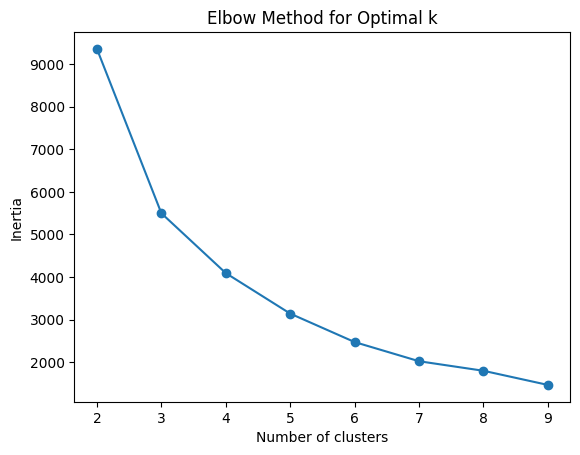

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


### 16. Train K-Means and Assign Cluster Labels

In [16]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1


### 17. Cluster Summary (Size and RFM Means)

In [17]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'Recency':'count'
}).rename(columns={'Recency':'Count'})
cluster_summary


,Count,Frequency,Monetary
Cluster,,,
0,3054,3.682711,1359.049284
1,1067,1.552015,480.617480
2,13,82.538462,127338.313846
3,204,22.333333,12709.090490


### 18. 3D Visualization of Customer Segments

In [18]:
import plotly.express as px

fig = px.scatter_3d(
    rfm, x='Recency', y='Frequency', z='Monetary',
    color=rfm['Cluster'].astype(str),
    title='Customer Segments in 3D'
)
fig.show()


### 19. RFM Feature Distributions

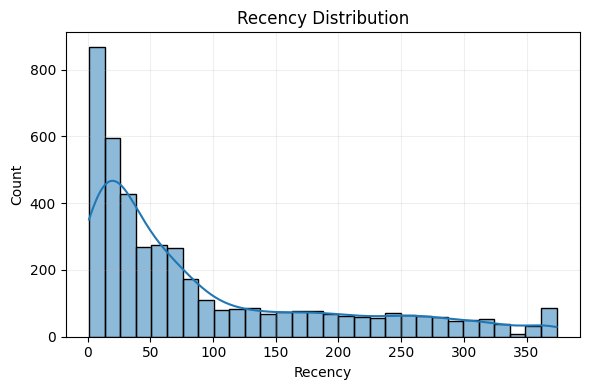

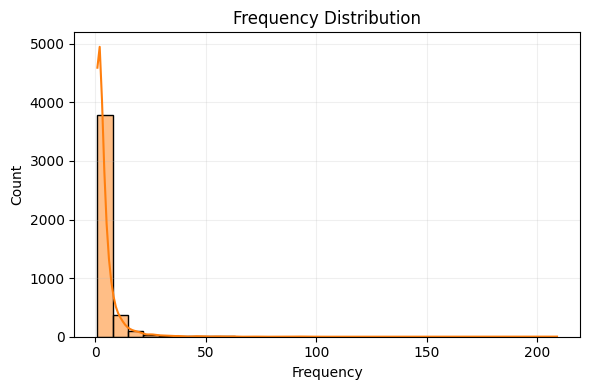

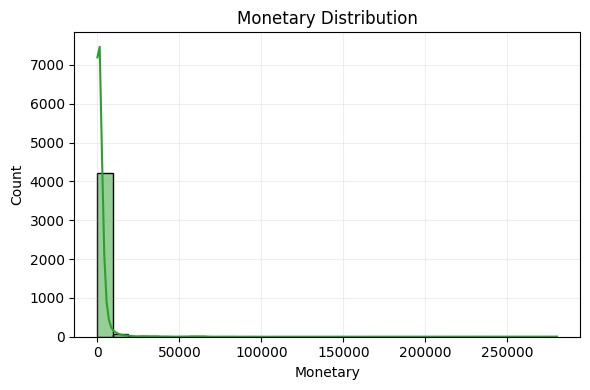

In [25]:
# Recency Distribution
plt.figure(figsize=(6, 4))
sns.histplot(rfm['Recency'], bins=30, kde=True, color='#1f77b4')
plt.title('Recency Distribution')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Frequency Distribution
plt.figure(figsize=(6, 4))
sns.histplot(rfm['Frequency'], bins=30, kde=True, color='#ff7f0e')
plt.title('Frequency Distribution')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Monetary Distribution
plt.figure(figsize=(6, 4))
sns.histplot(rfm['Monetary'], bins=30, kde=True, color='#2ca02c')
plt.title('Monetary Distribution')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


### 20. Correlation Heatmap (RFM)

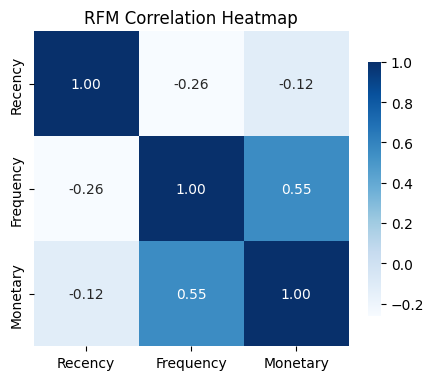

In [20]:
corr = rfm[['Recency','Frequency','Monetary']].corr()
plt.figure(figsize=(4.5,3.8))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', square=True, cbar_kws={'shrink':0.8})
plt.title('RFM Correlation Heatmap')
plt.tight_layout()
plt.show()

### 21. Cluster Profiles — Mean RFM per Cluster

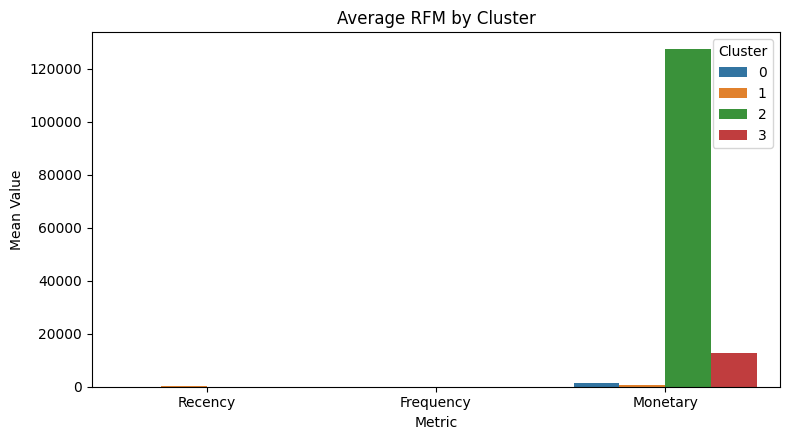

,Cluster,Recency,Frequency,Monetary
0,0,43.70,3.68,1359.05
1,1,248.08,1.55,480.62
2,2,7.38,82.54,127338.31
3,3,15.50,22.33,12709.09


In [21]:
profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2).reset_index()
melted = profile.melt(id_vars='Cluster', var_name='Metric', value_name='Value')
plt.figure(figsize=(8,4.5))
sns.barplot(data=melted, x='Metric', y='Value', hue='Cluster', palette='tab10')
plt.title('Average RFM by Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Metric')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
profile

### 22. 2D Scatter — Recency vs Monetary (by Cluster)

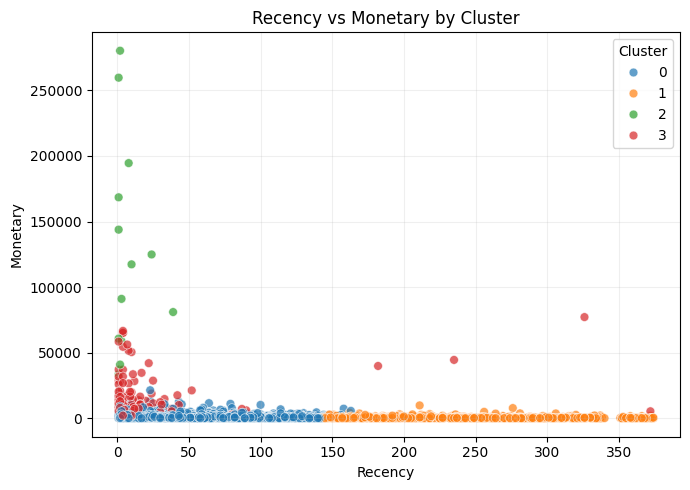

In [22]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=rfm.reset_index(), x='Recency', y='Monetary', hue='Cluster', palette='tab10', alpha=0.7, s=40)
plt.title('Recency vs Monetary by Cluster')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### 23. 2D Scatter — Frequency vs Monetary (by Cluster)

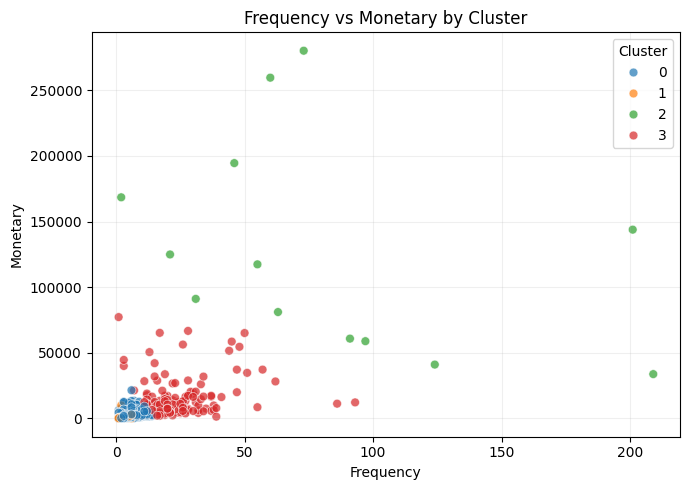

In [23]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=rfm.reset_index(), x='Frequency', y='Monetary', hue='Cluster', palette='tab10', alpha=0.7, s=40)
plt.title('Frequency vs Monetary by Cluster')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## 24. Conclusion

### **Summary**

The customer segmentation produced four distinct groups. Cluster 2 represents VIP customers who buy most frequently and spend the most, requiring premium retention strategies. Cluster 3 includes loyal and high-frequency buyers suitable for cross-selling and loyalty rewards. Cluster 0 forms the majority with moderate spending and frequency, showing potential for growth through personalized promotions. Cluster 1 consists of inactive or at-risk customers needing reactivation campaigns. Overall, applying targeted marketing, personalized offers, and monitoring KPIs like retention, order value, and CLTV will enhance customer engagement and business growth.


----